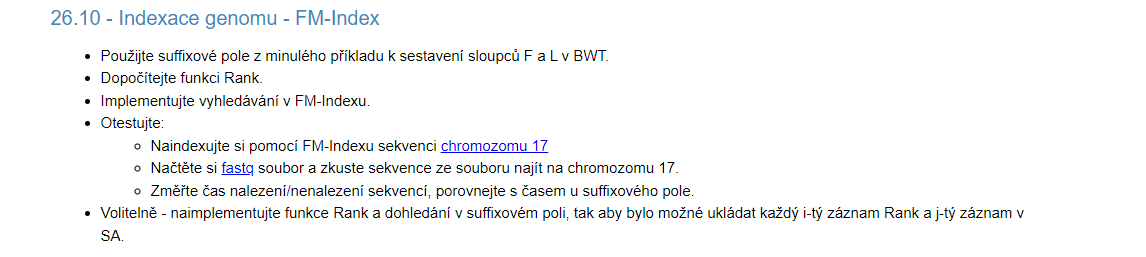

# Info about project

- udělat rešerši
- vyřešit implementační úkol

# Load fastq and chromozome

In [2]:
def complement(seq):
    return seq.translate(str.maketrans({'T': 'A', 'A': 'T', 'G': 'C', 'C': 'G'}))

In [3]:
def reverse(seq):
    return seq[::-1]

In [4]:
def load_fastq(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        lines = [l.replace('\n', '') for l in lines]
        text = ''.join(lines)
        return find_all(text)

In [5]:
def find_all(text):
    seq = []
    while True:
        f_t = 'N:0:52'
        s_t = '+'
        len_f = len(f_t) 
        len_s = len(s_t)
        f = text.find(f_t)
        s = text.find(s_t)
        if f == -1 or s == -1:
            break
        seq.append(text[f+len_f:s])
        text = text[s+len_s:]
    return seq

In [6]:
def load_chromozome(path):
    chr17 = ''
    with open(path, 'r') as f:
        chr17 = f.readlines()
        chr17 = chr17[1:]
        chr17 = [l.replace('\n', '').lower() for l in chr17]
    return ''.join(chr17)

In [7]:
import time
import numpy as np
from collections import Counter

In [8]:
def run_with_index(input_text, seq):
    input_text = input_text + "$"
    tic1 = time.time()
    array_index = create_suffix_array_index(input_text)
    toc1 = time.time()
    tic2 = time.time()
    positions = binary_search_index(array_index, seq, input_text)
    toc2 = time.time()
    return positions, (toc1 - tic2), (tic2 - toc2)

In [9]:
path_r1 = f'.//data//fastq//fastq_R1.fastq'

In [10]:
path_r2 = f'.//data//fastq//fastq_R2.fastq'

In [11]:
r1 = load_fastq(path_r1)
r1

['CTTTCCACTTGATAAGAGGTCCCAAGACTTAGTACCTGGAGGGTGAAATATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGG',
 'CTTTCCACTTGATAAGAGGTCCCAAGACTTAGTACCTGAAGGGTGAAATATTCTCCATCCAGTGGTTTCTTCTTTGGCTGGGGAGAGGAGCTGGTGTTGTTGGGCAGTGCTAGGAAAGAGGCAAGGAAAGGTGATAAAAGTGAATCTGAGG',
 'CAGGACTGCTCGAGCCGGGGAGGCAAAGGCTGCAGTAAGCCAAGATCACGCCACTCCACTCCAGCCTGGGCAACAAAGCGAGACCCAGTCTCAAAGAAAAAGAAAAAAAAAAAAAAAAGAAAAAAGAAATTGACCCTGAGCATAAAACAAG']

In [12]:
r2 = load_fastq(path_r2)
r2

['TAAGCAAGCAGGACAAGAAGCGGTGGAGGAGACCAAGGGTGCAGTTATGCCTCAGATTCACTTTTATCACCTTTCCTTGCCTCTTTCCTAGCACTGCCCAACAACACCAGCTCCTCTCCCCAGCCAAAGAAGAAACCACTGGATGGAGAAT',
 'TAAGCAAGCAGGACAAGAAGCGGTGGAGGAGACCAGGGTGCGGTTATGCCTCAGATTCACTTTTATCACCTTTCCTTGCCTCTTTCCTAGCACTGCCCAACAACACCAGCTCCTCTCCCCAGCCAAAGAAGAAACCACTGGATGGAGAATA',
 'CCTGGAGGATTTCATCTCTTGTATATGATGATCTGGATCCACCAAGACTTGTTTTATGCTCAGGGTCAATTTCTTTTTTCTTTTTTTTTTTTTTTTCTTTTTCTTTGAGACTGGGTCTCGCTTTGTTGCCCAGGCTGGAGTGGAGTGGCGT']

In [13]:
r2 = [complement(reverse(r)) for r in r2]

path = f'.\data\chr17\chr17.fa'
ref = load_chromozome(path);

# Implementation

## Použijte suffixové pole z minulého příkladu k sestavení sloupců F a L v BWT.

In [14]:
import functools
import numpy as np
import pandas as pd

In [15]:
T = 'abaaba$'

In [16]:
def compare(x0, x1):    
    if x0>(len(T)-1):
        return -1
    
    if x1>(len(T)-1):
        return 1
    
    if T[x0] > T[x1]:
        return 1
    
    if T[x0] < T[x1]:
        return -1
    return compare(x0+1, x1+1)

In [17]:
def create_suffix_array_index(T):
    indicies = list(range(len(T)))
    indicies = sorted(indicies, key=functools.cmp_to_key(compare))
    return indicies

In [18]:
def indicies_to_chars(text, indicies):
    return [text[i] for i in indicies]

In [19]:
def get_counter_to(index, text):
    counter = 0
    current_char = text[index]
    i = 0
    while i < index:
        if current_char == text[i]:
            counter += 1
        i += 1
    return counter

In [20]:
def get_character_index(index, text):
    current_character = text[index]
    
    if current_character == '$':
        return current_character, 0
    
    counter = get_counter_to(index, text)
    return current_character, counter

In [21]:
def build_L(F_index, text):
    counter = {}
    L = []
    for i in F_index:
        current_c = text[i-1]
        current_i = counter.get(current_c, 0)
        if i > 0:
            L.append((current_c, current_i))
        else:
            L.append(('$',0))
        counter[current_c] = counter.get(current_c, 0) + 1 
    return L

In [22]:
def build_F_L(text):
    #Znak a cislo
    #V praxi symboly indexujeme podle jejich výskytu ve sloupci L!
    SA = np.array(create_suffix_array_index(text))
    F_dic = {}
    
    for char in indicies_to_chars(text, SA):
        F_dic[char] = F_dic.get(char, 0) + 1
            
    L = build_L(SA, text)
    #F = [get_character_index(index, text) for index in F_index]
    return F_dic, L, SA

In [23]:
F_dic, L, SA = build_F_L(T)

## Dopočítejte funkci Rank.

In [24]:
def calc_rank(L, text):
    transformed = text[:-1]
    uni = np.unique(list(transformed))
    
    data = np.zeros(shape=(len(text), len(uni)))
    df = pd.DataFrame(data, columns=uni)
    
    for i in range(len(L)):
        current_c = L[i][0]
        
        if i != 0:
            row_up = data[i-1]
            data[i] = row_up
        
        if current_c == '$':
            continue

        df.loc[i, current_c] += 1    
        
    return df

In [25]:
rank = calc_rank(L, T)
rank

,a,b
0,1.0,0.0
1,1.0,1.0
2,1.0,2.0
3,2.0,2.0
4,2.0,2.0
5,3.0,2.0
6,4.0,2.0


## Implementujte vyhledávání v FM-Indexu.

In [26]:
def get_from_rank(rank, top, bot, c):
    top = top - 1
    
    
    top_i = rank.loc[top, c]
    bot_i = rank.loc[bot, c]
    
    return top_i, bot_i - 1 

In [27]:
def get_start_end(F_dic, k, k2I, c):
    start = F_dic[k[k2I[c] - 1]]
    end = F_dic[c]
    return start, end

In [28]:
def get_pos(F_dic, index, c):
    k = list(F_dic.keys())
    k2I = {key:i for i, key in enumerate(k)}

    current_index = k2I[c]
    count = 0
        
    for i in range(current_index):
        count += F_dic[k[i]]
        
    count += index
    return count

In [29]:
def build_response(f, t, SA):
    return SA[int(f):int(t)+1]

In [30]:
def search(F_dic, L, rank, SA, seq):    
    top = 0
    bot = 0
    
    k = list(F_dic.keys())
    k2I = {key:i for i, key in enumerate(k)}
    
    max_l = len(seq)-1

    c = seq[-1]
    start, end = get_start_end(F_dic, k, k2I, c)

    current = c
    
    for i in range(max_l, 0, -1):
        
        if start > end:
            print(F'P = {seq} not founded :-(')
            return None
        
        c = seq[i]
        prev_c = seq[i-1] 
        ranks = get_from_rank(rank, start, end, prev_c)
        start = get_pos(F_dic, ranks[0], prev_c)
        end = get_pos(F_dic, ranks[1], prev_c)
        
        current = prev_c + current
                
        if current == seq:
            print(f'Founded! => < {start}; {end} >')

    return build_response(start, end, SA)

In [31]:
search(F_dic, L, rank, SA, 'aba')

Founded! => < 3.0; 4.0 >


array([3, 0])